In [12]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys

from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import copy
import torchvision.models as models
import torch.nn as nn
from clustimage import Clustimage
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image
import pandas as pd
from os import listdir
from sklearn.metrics import pairwise_distances_argmin_min
 
from os.path import isfile, join


PyTorch version: 2.3.0.dev20231230+rocm5.7
Torchvision version: 0.18.0.dev20231230+rocm5.7
CUDA is available: True


In [13]:
cl = Clustimage(method='pca',embedding='tsne',dirpath='./out',store_to_disk=True, dim=(256, 256), params_pca={'n_components':0.95})
cl.load(filepath='./out/backup_clustimage.pkl')
results = cl.results

classes = np.unique(results['labels'])
k = len(classes)

[pypickle] Pickle file loaded: [./out/backup_clustimage.pkl]


[clustimage] >INFO> Load succesful!


In [14]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_list, labels, transformations = None, original:bool = False):
        super(CustomImageDataset, self).__init__()
        self.img_list = img_list
        self.labels = labels
        self.og = original
        self.transformations = transformations

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image_filepath = self.img_list[idx]
        og_filepath = image_filepath.replace("modv2_moncouche_HD", "moncouche_HD").replace("SAM_", "")
        image = torchvision.io.read_image(image_filepath) if self.og==False else torchvision.io.read_image(og_filepath)
        resize = torchvision.transforms.Resize((256,256))
       
        image = resize(image)
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transformations is not None:
            image = self.transformations(image=image)["image"]
        
        lab = self.labels[idx]
        return image, torch.tensor(lab, dtype=torch.float32)

In [15]:


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)  # Update input channels to 1
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.05)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(524288, 512)  # Adjust input size based on image dimensions
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.05)
        self.fc4 = nn.Linear(512, 256)
        self.act4 = nn.ReLU()
        self.fc5 = nn.Linear(256, num_classes)
        
        self.act5 = nn.Sigmoid()
        
 
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        #x = torch.nn.Linear(x.shape[1], 512)(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        
        return x
        
        
        

# Import testing dataset



In [16]:
path_test_dir= '../test_phase_moncouche/'
all_images = [path_test_dir + f for f in listdir(path_test_dir) if isfile(join(path_test_dir, f))]

# Define metrics

In [17]:
def find_similarity_analysis(image_path, cl, metric, k, alpha=0.05) -> dict :
    results_find = cl.find(Xnew =image_path, metric = metric, k=k, alpha=alpha)
    
    # Show whatever is found. This looks pretty good.
    cl.plot_find()
    # Extract the first input image name
    filename = [*results_find.keys()][1]
    # Extract the cluster labels for the input image
    results_find[filename]['labels']

    # The majority of labels 
    label = pd.value_counts(results_find[filename]['labels'])
    print(label)
    
    percentage_clust = (label/np.sum(label)).to_dict()
    
    return percentage_clust

In [18]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length


def find_SSIM_Centroid(path_new_image, cl, k) -> dict :
    new_image = cv2.imread(path_new_image) 
    img_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    results = cl.results
    ssim_dic = {}
    #centroid_list = []
    for i in classes:
        mask = results['labels'] == i
        points = results['xycoord'][mask]
        pics = results['pathnames'][mask]
        centroid = np.array([centeroidnp(points)])
        
        cl2, dst2 = pairwise_distances_argmin_min(centroid, points)
        print(pics[cl2][0])
        
        image = cv2.imread(str(pics[cl2][0]), cv2.COLOR_BGR2GRAY)
        #cv2.imshow('fen',image)
        #cv2.waitKey(0)
        #centroid_list += [[i, centroid, pics[cl2], image]]
        
        
        (score, diff) = compare_ssim(img_gray, image, full=True, gaussian_weights=True)
        ssim_dic[f"{i}"] = score/k
        #diff = (diff * 255).astype("uint8")
        print(f"cluster: {i}")
        print("SSIM: {}".format(score)) # expected
    return ssim_dic

In [19]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
my_model = CNN(num_classes=6).to(device)
my_model.load_state_dict(torch.load("OurCNN.pth"))
my_model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (drop1): Dropout(p=0.05, inplace=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=524288, out_features=512, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.05, inplace=False)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (act4): ReLU()
  (fc5): Linear(in_features=256, out_features=6, bias=True)
  (act5): Sigmoid()
)

In [20]:
def get_CNN_pred(filepath, model, lambd):
    og_filepath = filepath.replace('test_phase_moncouche', 'moncouche_HD').replace('SAM_', '')
    image = torchvision.io.read_image(og_filepath) 
    resize = torchvision.transforms.Resize((256,256))

    image = resize(image)
    image_tensor = torch.tensor(image, dtype=torch.float32)
    image_tensor = image_tensor.to(device).float().unsqueeze(0)
    model.eval()
    pred_CNN = model.forward(image_tensor)
    pred_CNN = (pred_CNN.detach().cpu().numpy())
    
    return lambd*pred_CNN/np.sum(pred_CNN)

In [21]:
def voting(percentage_simi_dict, SSIM_centroid_dict, CNN_vec, classes, no_snow_class):
    vote = {}
    count = 0
    test1 = (max(percentage_simi_dict) == no_snow_class) 
    test2 = (max(SSIM_centroid_dict) == no_snow_class) 
    test3 = (np.argmax(CNN_vec)==3)
    and_gate = test1 and test2 and test3
    or_gate = test1 or test2 or test3
        
    if or_gate and not and_gate:
        w1 = not test1
        w2 = not test2 
        w3 = not test3
    else:
        w1 = 1
        w2 = 1
        w3 = 1
        
        
    for elem in classes:
        vote[f'{elem}'] = w1*(percentage_simi_dict[f'{elem}'] if f'{elem}' in percentage_simi_dict.keys() else 0) + w2*(SSIM_centroid_dict[f'{elem}'] if f'{elem}' in SSIM_centroid_dict.keys() else 0) + w3*CNN_vec[:,count]
        count += 1
        
    
        
    print(vote)
    return max(vote, key=vote.get)

# Test !!!

[clustimage] >INFO> Find similar images with metric [euclidean], k-nearest neighbors: 6 and under alpha: 0.05 
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Reading and checking images.
[clustimage]:   0%|          | 0/1 [00:00<?, ?it/s]

[clustimage]: 100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


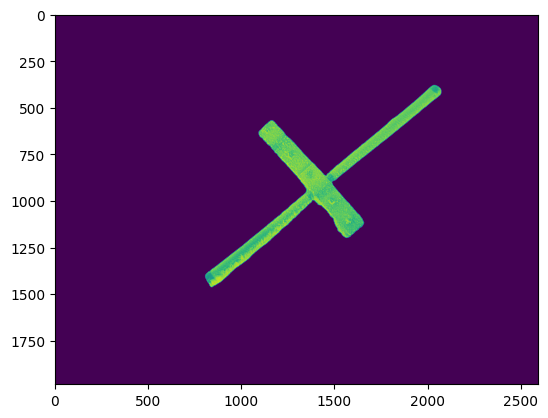

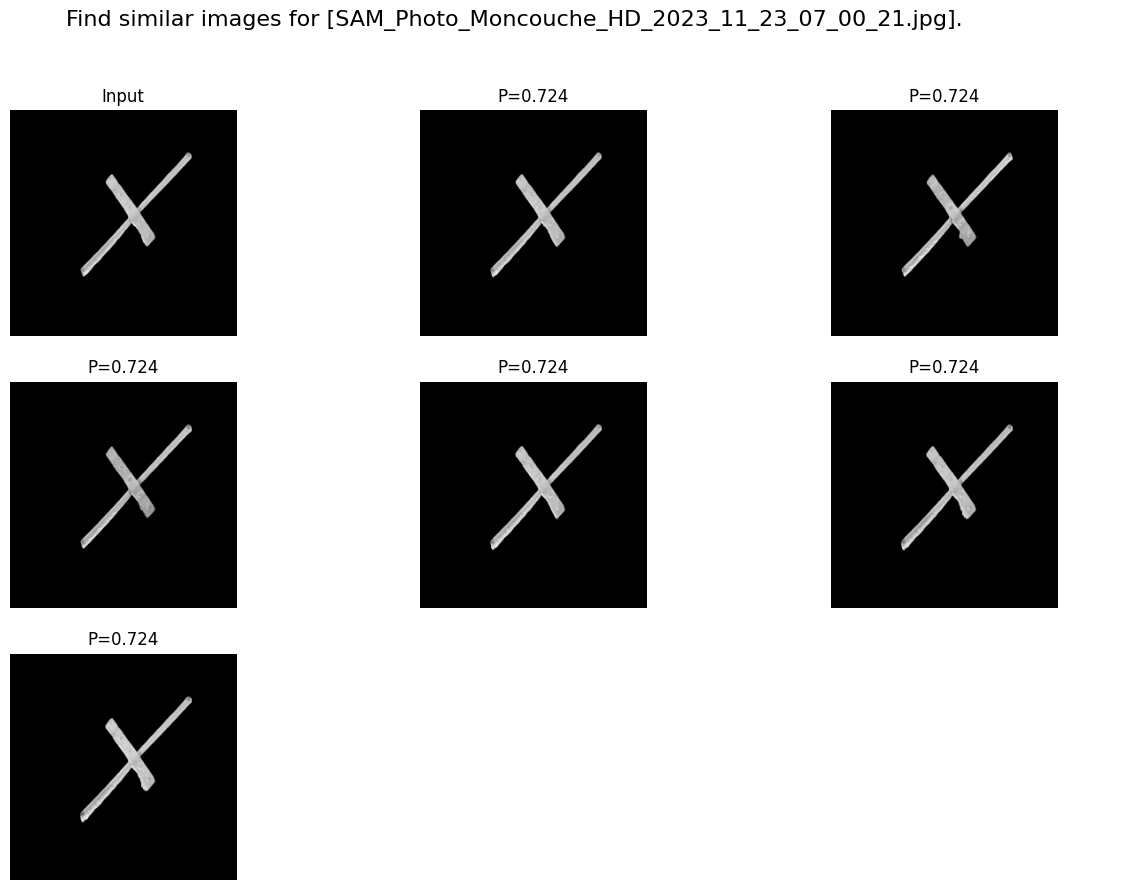

labels
2    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.904484346466291
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.8947983081583054
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9536456964451177
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9540520897010241
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6461271789956691
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9541294930828995
[[2.0690749  0.34561795 1.4711511  0.8452749  0.18239988 0.08648097]]
{'-1': array([2.2198222], dtype=float32), '0': array([0.494751], dtype=float32), '1': array([1.630092], dtype=float32), '2': array([1.0042837], dtype=float32), '3': array([0.29008776], dtype=float32), '4': array([0.24550256], dtype=float32)}
-1


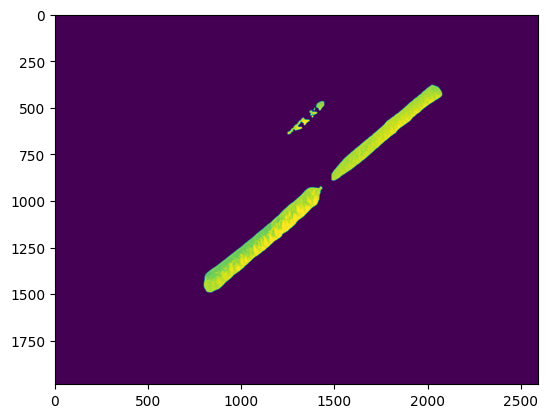

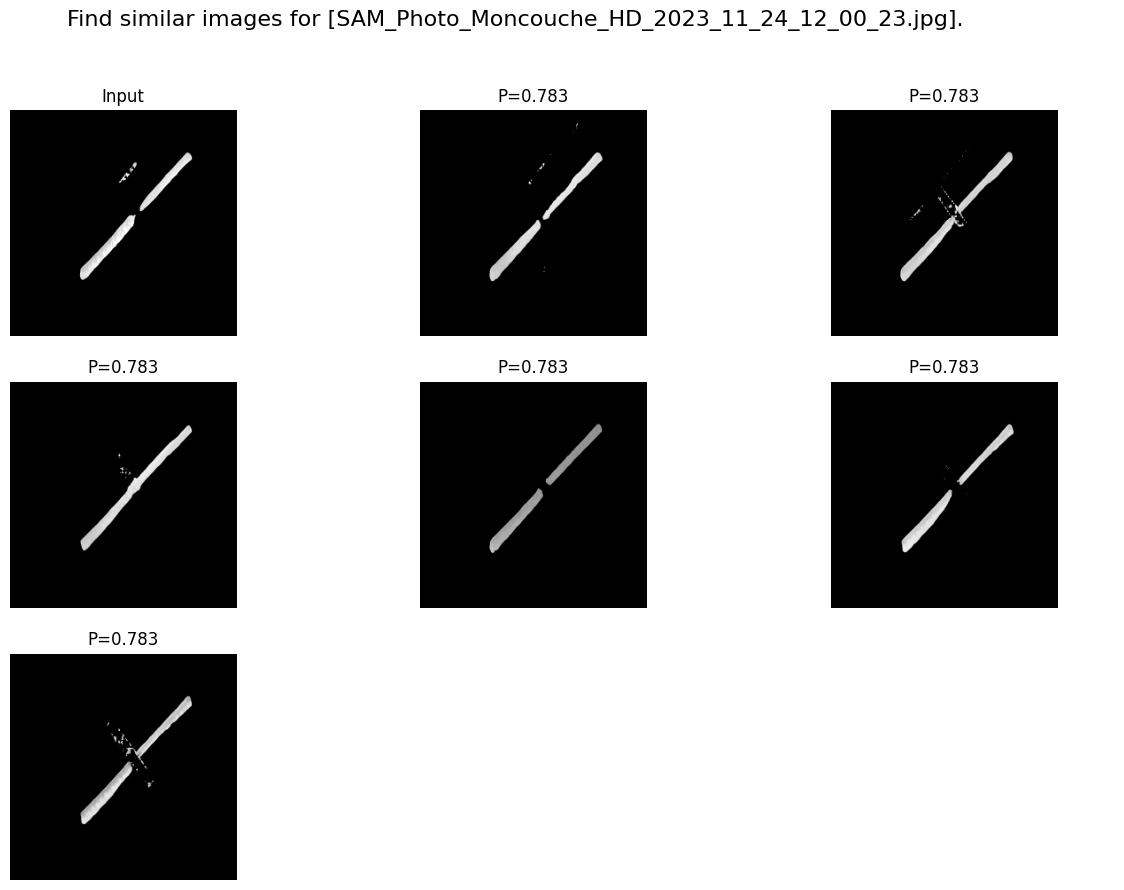

labels
2    5
4    1
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9106263566332984
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.89738618552546
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9621242236647282
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9500188539068296
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6490650618431815
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9491994058135755
[[2.5418935  1.020594   1.0144197  0.12380512 0.2155511  0.08373678]]
{'-1': array([2.6936646], dtype=float32), '0': array([1.1701584], dtype=float32), '1': array([1.1747737], dtype=float32), '2': array([0.2821416], dtype=float32), '3': array([0.32372862], dtype=float32), '4': array([0.24193668], dtype=float32)}
-1


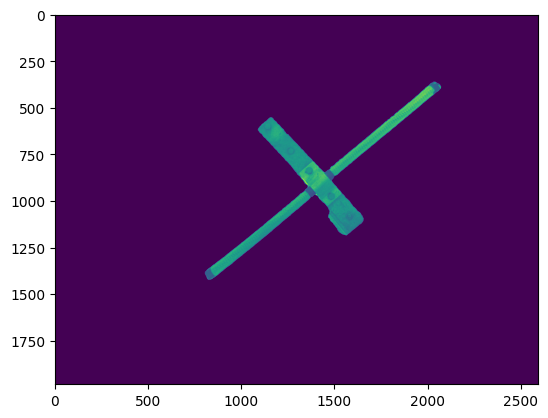

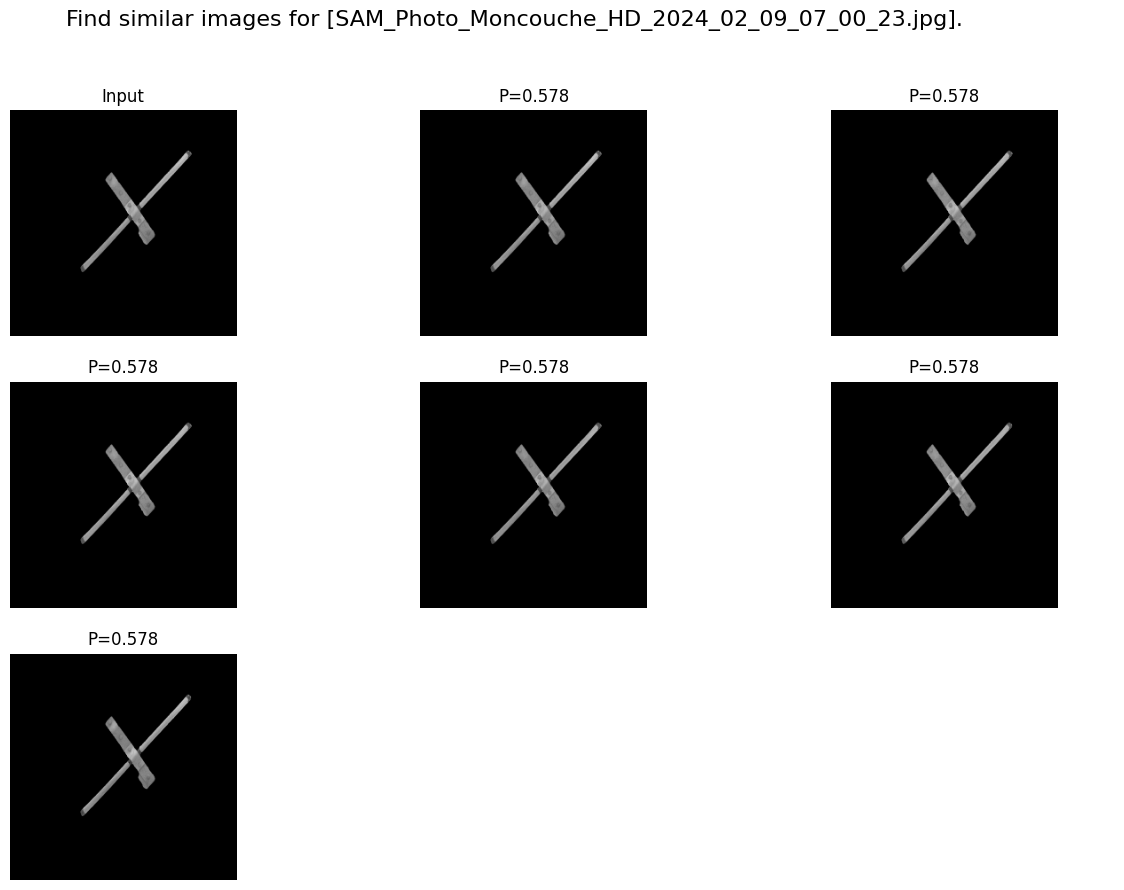

labels
2    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9022420777050411
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.8948283871792527
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9496928007519458
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9638518045545207
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.644404446980065
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.953591251901615
[[0.05307916 0.00707381 0.8879838  3.7642376  0.1207725  0.16685322]]
{'-1': array([0.15037368], dtype=float32), '0': array([0.14913806], dtype=float32), '1': array([0.15828213], dtype=float32), '2': array([0.16064197], dtype=float32), '3': array([0.10740074], dtype=float32), '4': array([0.15893188], dtype=float32)}
2


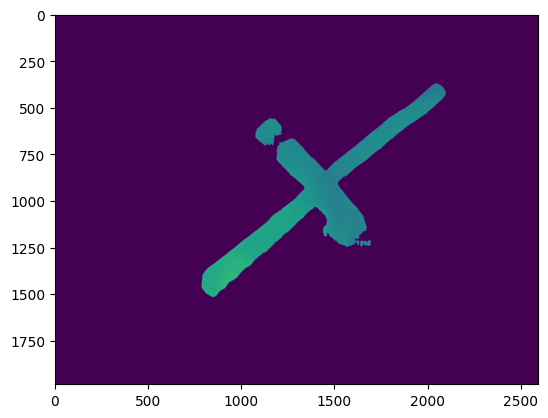

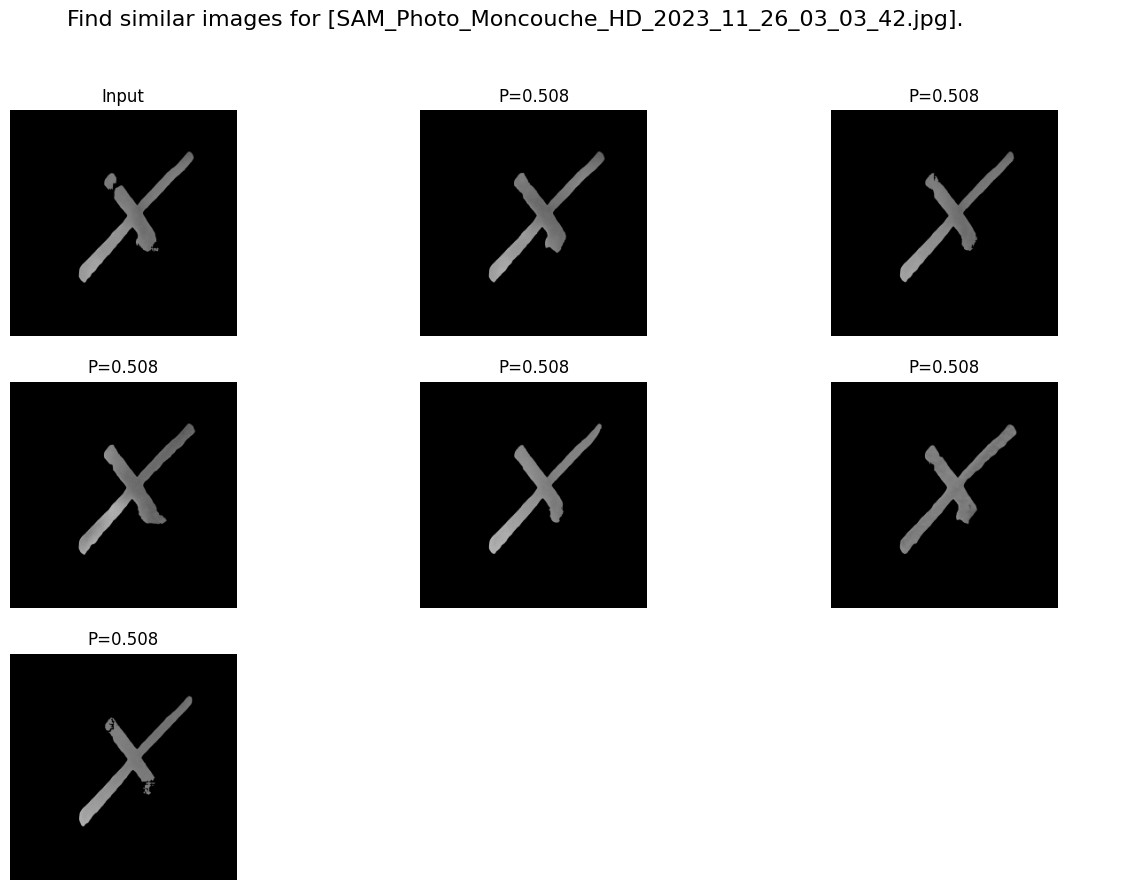

labels
2    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.90836986658864
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.9041000031805618
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9478705839816889
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9435655998863091
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6509069809692773
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9490650825522857
[[0.48525596 0.9309091  0.4572299  1.9757639  0.3705006  0.78034073]]
{'-1': array([0.15139498], dtype=float32), '0': array([0.15068333], dtype=float32), '1': array([0.15797843], dtype=float32), '2': array([0.15726094], dtype=float32), '3': array([0.1084845], dtype=float32), '4': array([0.15817751], dtype=float32)}
4


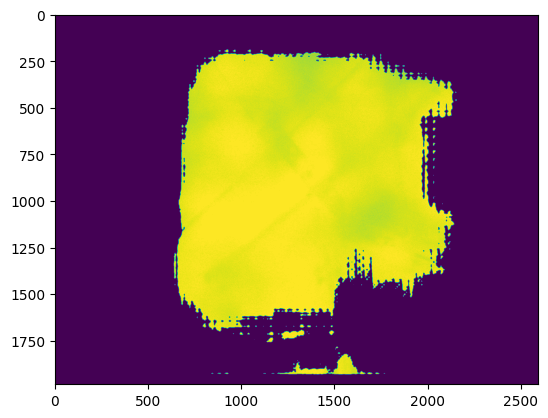

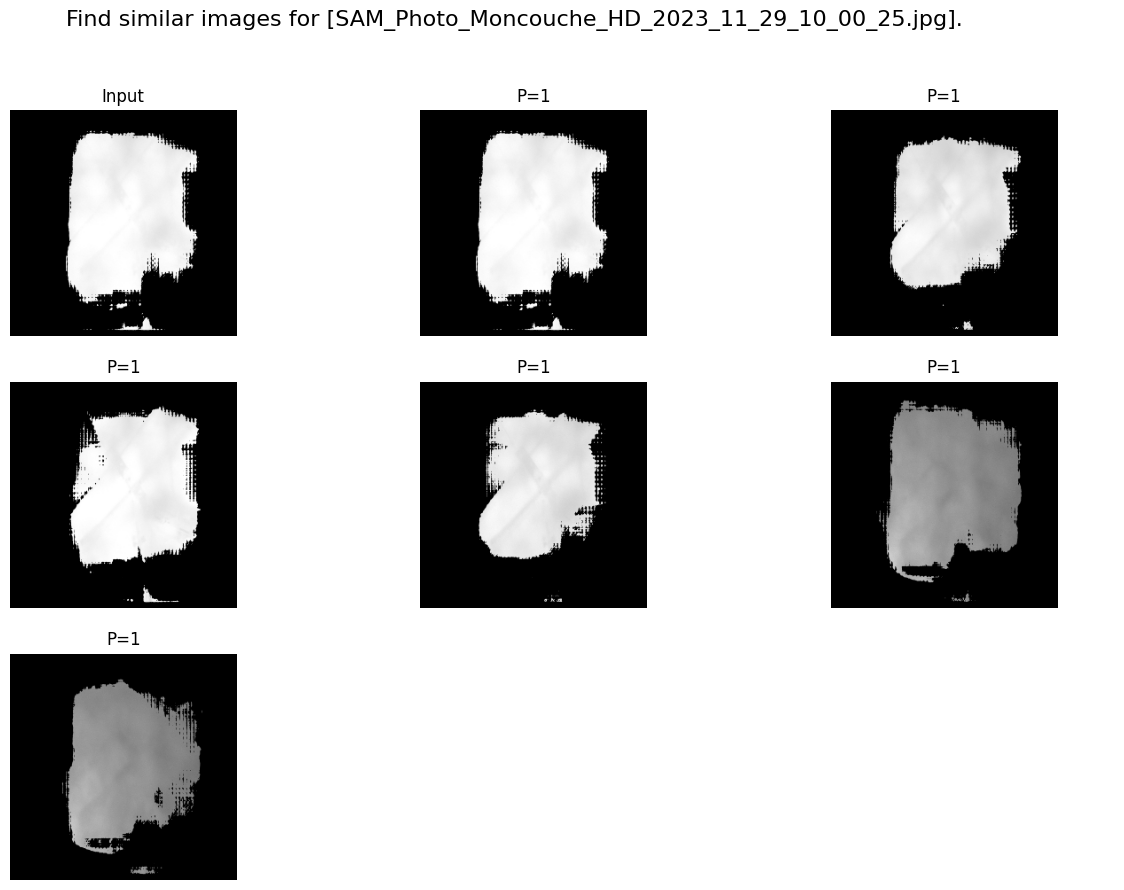

labels
3    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.6930771226955823
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.6574195360989932
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.6525495224302439
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.6444253805100166
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 1.0
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.6414476051831378
[[2.6779191  0.6115615  1.0771902  0.30012012 0.2786239  0.05458499]]
{'-1': array([2.793432], dtype=float32), '0': array([0.7211314], dtype=float32), '1': array([1.1859484], dtype=float32), '2': array([0.40752435], dtype=float32), '3': array([0.44529057], dtype=float32), '4': array([0.16149293], dtype=float32)}
-1


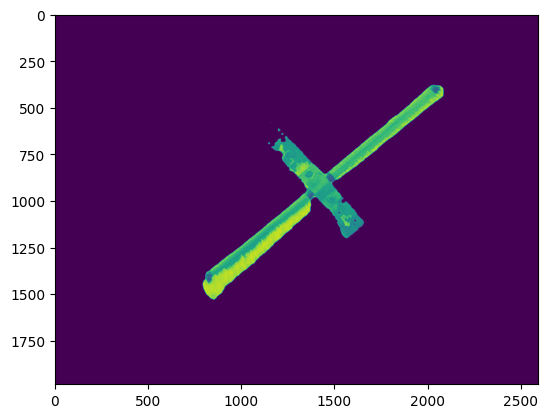

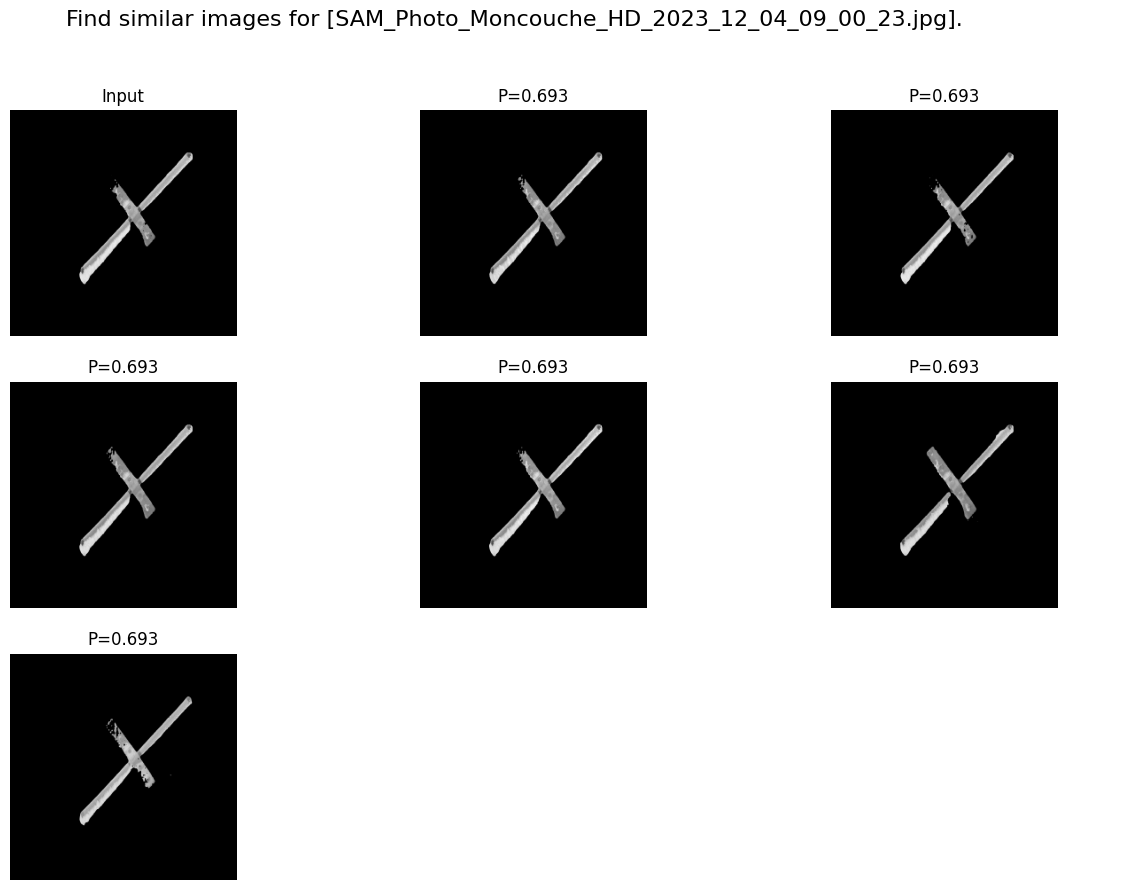

labels
1    5
2    1
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9108235310367111
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.8991906729253527
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9559685749152553
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9488928816962299
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6498874519381508
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9503949248514744
[[1.4682294  0.24927315 1.8673708  1.1500612  0.17008245 0.09498316]]
{'-1': array([1.6200334], dtype=float32), '0': array([0.39913827], dtype=float32), '1': array([2.026699], dtype=float32), '2': array([1.30821], dtype=float32), '3': array([0.27839702], dtype=float32), '4': array([0.25338233], dtype=float32)}
1


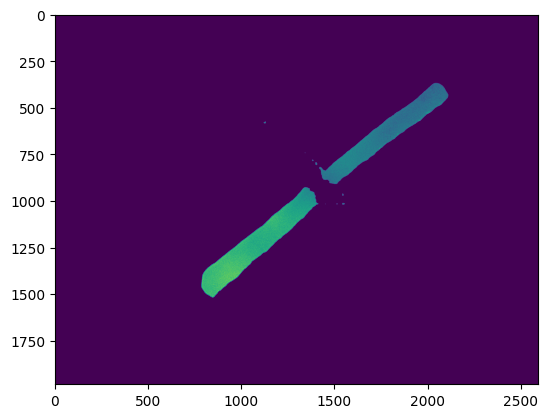

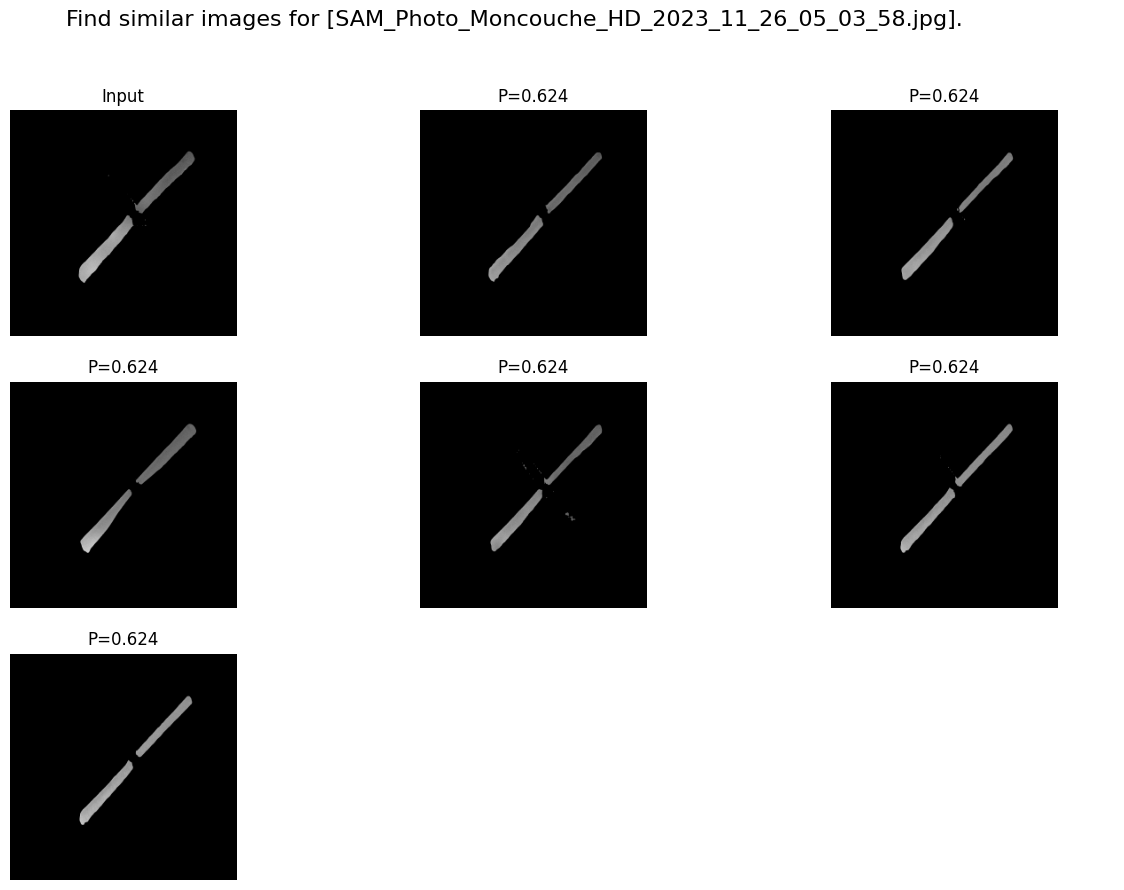

labels
4    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9058027213807303
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.9014778487042115
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.952543694098831
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9460795490200872
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6439837149873364
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9497317055692287
[[0.33124012 1.2996672  0.33612072 1.9263126  0.30571535 0.80094385]]
{'-1': array([0.15096712], dtype=float32), '0': array([0.1502463], dtype=float32), '1': array([0.15875728], dtype=float32), '2': array([0.15767993], dtype=float32), '3': array([0.10733062], dtype=float32), '4': array([0.15828861], dtype=float32)}
1


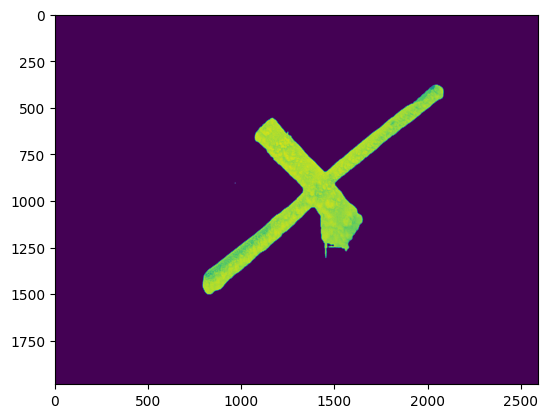

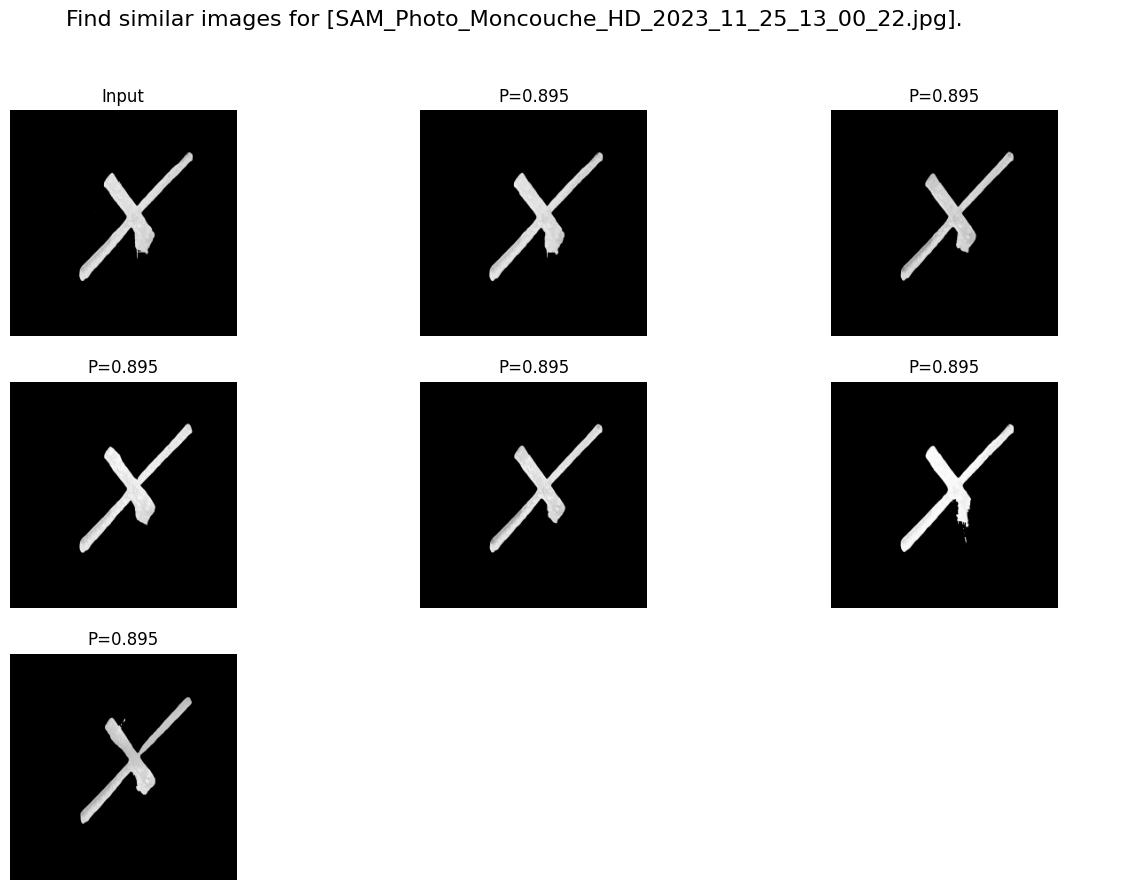

labels
1    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.916881430079467
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.8983599614669613
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9591956440464462
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9476056821325056
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.661963915454415
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9458387084278623
[[2.1309452  0.5313614  1.6680079  0.3906697  0.20082507 0.07819067]]
{'-1': array([2.2837589], dtype=float32), '0': array([0.6810881], dtype=float32), '1': array([1.8278738], dtype=float32), '2': array([0.548604], dtype=float32), '3': array([0.3111524], dtype=float32), '4': array([0.23583046], dtype=float32)}
-1


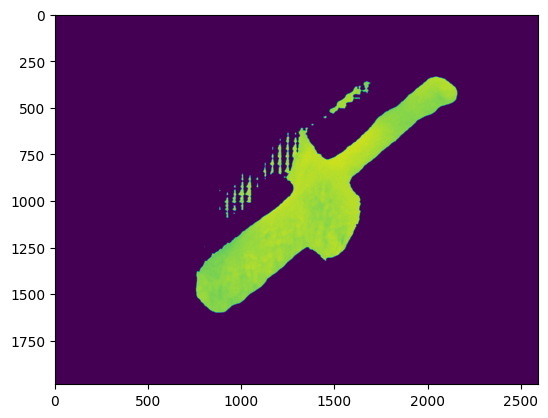

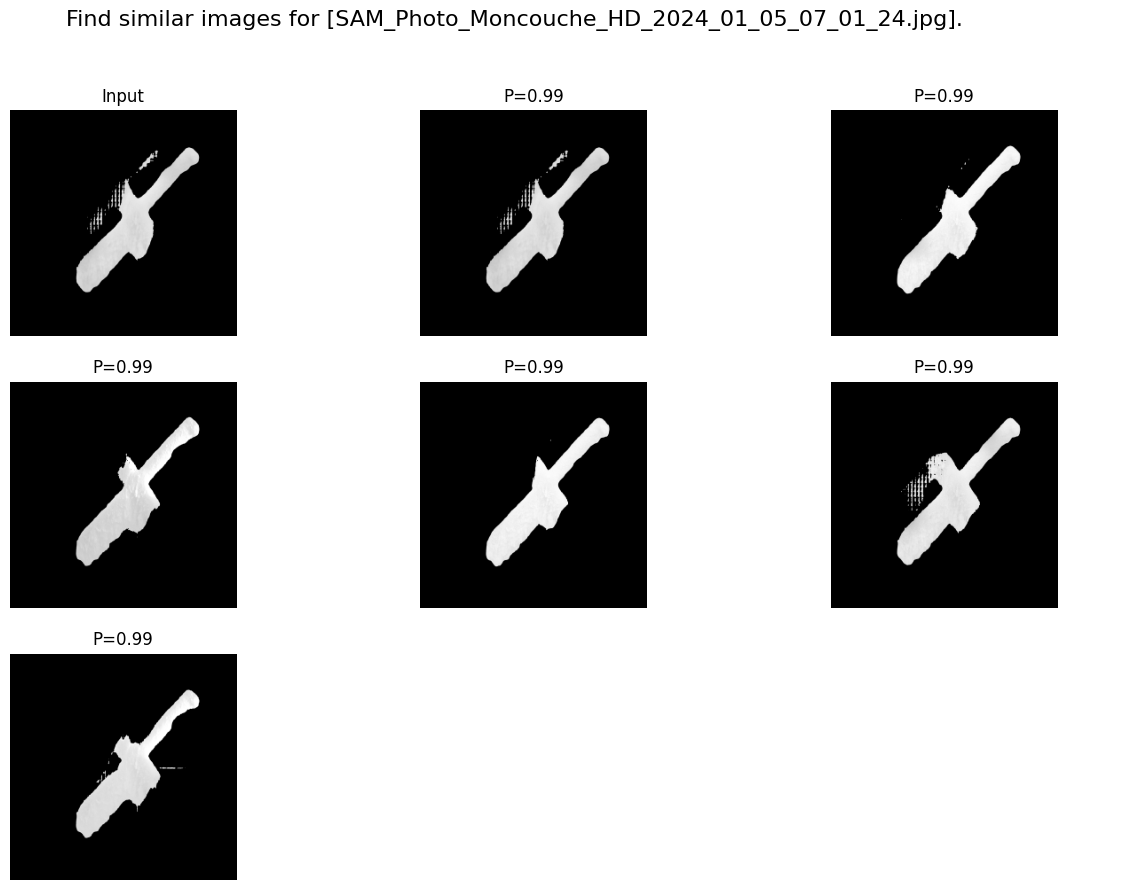

labels
-1    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9301172221086994
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.9130287721921083
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9105623817881954
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9020155263241108
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6908412667217014
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9028689751438568
[[1.9264158  0.6982768  0.6647784  0.8635544  0.6009896  0.24598521]]
{'-1': array([2.0814354], dtype=float32), '0': array([0.85044825], dtype=float32), '1': array([0.8165388], dtype=float32), '2': array([1.0138904], dtype=float32), '3': array([0.7161298], dtype=float32), '4': array([0.3964634], dtype=float32)}
-1


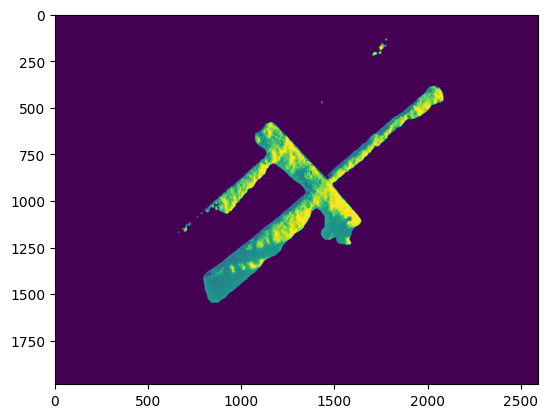

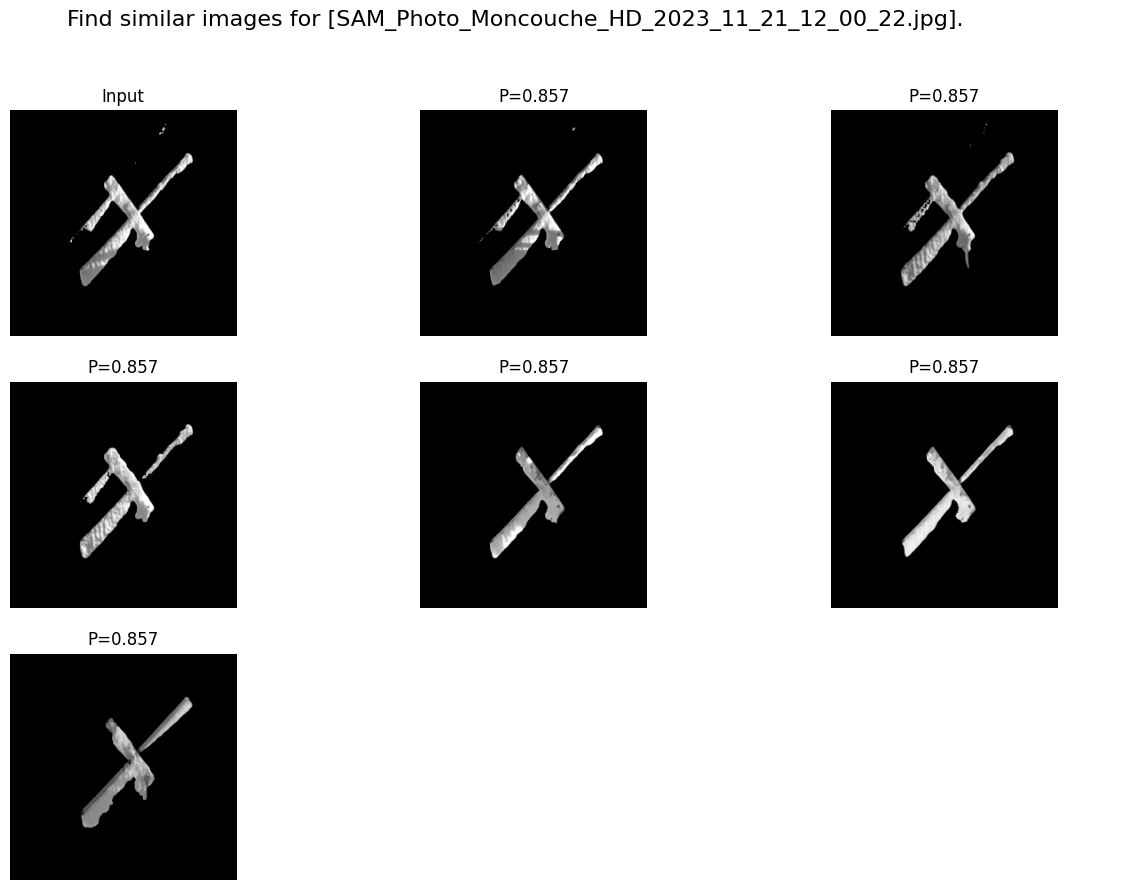

labels
1    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9026572615531985
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.8916984207434959
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9366292091843416
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9331716282053814
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6553182981415101
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.9327083783725484
[[1.4101636 0.7712257 1.8426528 0.6651889 0.1526892 0.1580793]]
{'-1': array([1.5606065], dtype=float32), '0': array([0.9198421], dtype=float32), '1': array([1.9987576], dtype=float32), '2': array([0.8207175], dtype=float32), '3': array([0.26190892], dtype=float32), '4': array([0.31353068], dtype=float32)}
1


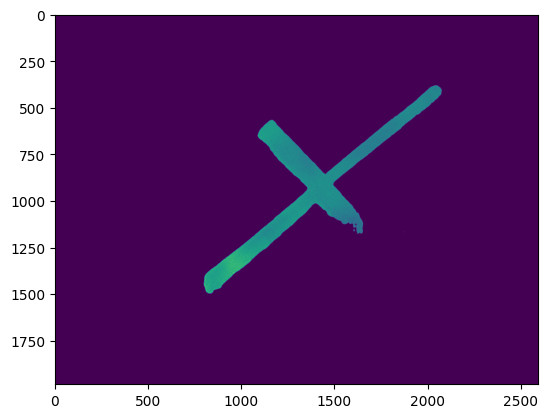

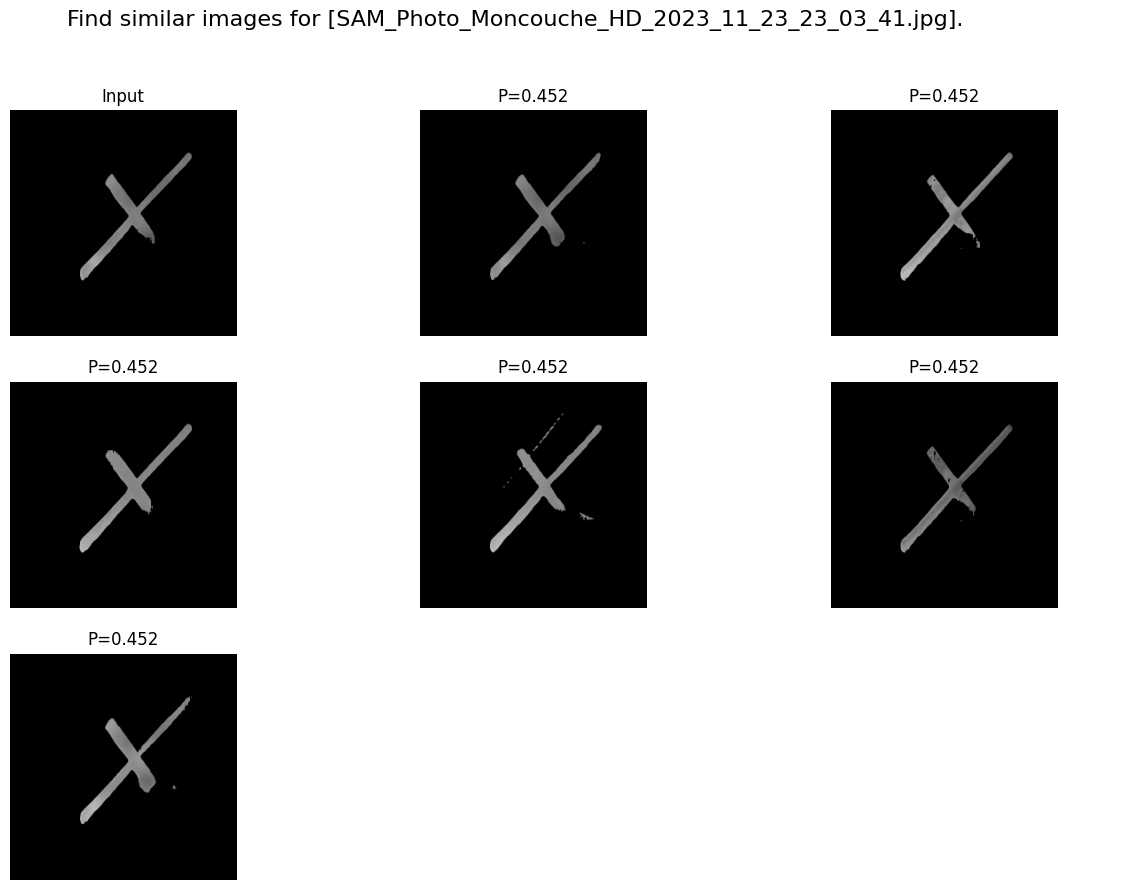

labels
2    6
Name: count, dtype: int64
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_04_09_00_21.jpg
cluster: -1
SSIM: 0.9038276082727382
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_06_17_03_41.jpg
cluster: 0
SSIM: 0.9003218327917359
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_25_10_00_21.jpg
cluster: 1
SSIM: 0.9541315668639813
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2024_01_30_17_00_22.jpg
cluster: 2
SSIM: 0.9519137768956892
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_11_29_10_00_25.jpg
cluster: 3
SSIM: 0.6458600505301213
../modv2_moncouche_HD/SAM_Photo_Moncouche_HD_2023_12_15_22_04_09.jpg
cluster: 4
SSIM: 0.956873061756844
[[0.37368336 0.5970605  0.4318603  2.0983357  0.39565608 1.1034044 ]]
{'-1': array([0.15063794], dtype=float32), '0': array([0.15005364], dtype=float32), '1': array([0.15902193], dtype=float32), '2': array([0.15865229], dtype=float32), '3': array([0.10764334], dtype=float32), '4': array([0.15947884], dtype=float32)}
4


In [22]:
votes = []
for img_path in all_images:
    img = Image.open(img_path)
    # Plotting the image
    plotting = plt.imshow(img)
    
    sim_dic = find_similarity_analysis(img_path, cl, 'euclidean',k)
    ssim_centro_dic = find_SSIM_Centroid(img_path, cl,k)
    CNN_vec = get_CNN_pred(img_path, my_model,5)
    print(CNN_vec)
    vote = voting(sim_dic, ssim_centro_dic, CNN_vec, classes, no_snow_class=2)
    votes += vote
    print(vote)